### Set up

In [3]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
from wordcloud import WordCloud
import collections 
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.cluster import KMeans
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
import numpy as np
plt.style.use('ggplot')

In [4]:
data = pickle.load(open("All_email.txt","rb"))

### Seperate to training /test data

In [5]:
#Seperate to training data/test data
train, test = train_test_split(data, test_size = 0.3)

### Plots

In [5]:
year_count = []
for i in ['1999','2000','2001','2002','2003','2004','2005','2006','2007']:
          c=collections.Counter(data[data['Year']==i]['Classification'])
          year_count.append(c)
pd.DataFrame(year_count,index=['1999','2000','2001','2002','2003','2004','2005','2006','2007'])

,ham,spam
1999,2978,4611
2000,8512,2851
2001,9872,848
2002,10663,5280
2003,545,1773
2004,627,13420
2005,1309,18418
2006,1226,2730
2007,25219,48999


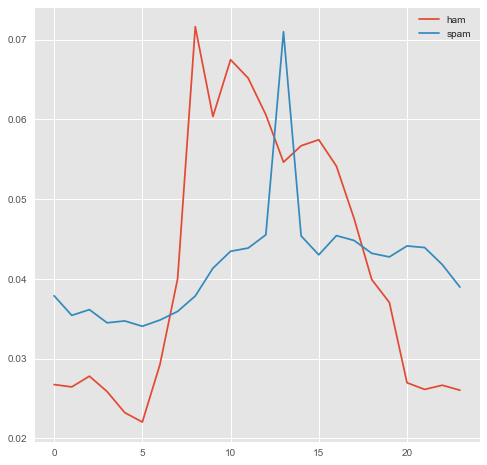

In [6]:
hour_count = []
hour  = ['00','01','02','03','04','05','06','07','08','09','10','11',
         '12','13','14','15','16','17','18','19','20','21','22','23']
for i in hour :
          c=collections.Counter(data[data['Hour']==i]['Classification'])
          hour_count.append(c)
hour_count = pd.DataFrame(hour_count,index=hour)



fig = plt.figure(figsize=[8,8])
line1, = plt.plot(hour_count['ham']/sum(hour_count['ham']), label='ham')
line2, = plt.plot(hour_count['spam']/sum(hour_count['spam']), label='spam')
plt.legend()
plt.show()

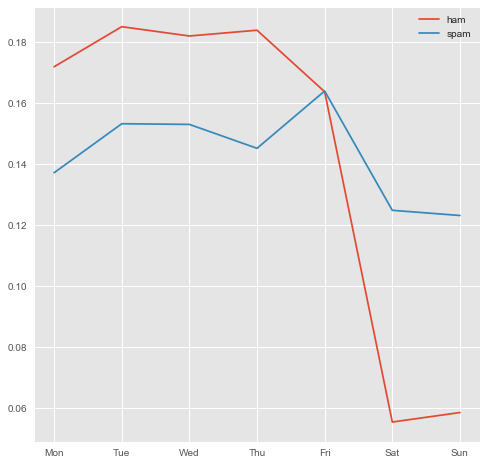

In [7]:
wd_count = []
wd  = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in wd :
          c=collections.Counter(data[data['Weekday']==i]['Classification'])
          wd_count.append(c)
wd_count = pd.DataFrame(wd_count,index=range(7))

fig = plt.figure(figsize=[8,8])
line1, = plt.plot(wd_count['ham']/sum(wd_count['ham']), label='ham')
line2, = plt.plot(wd_count['spam']/sum(wd_count['spam']), label='spam')
plt.xticks(range(7),wd)
plt.legend()
plt.show()

### Feature Engineering

In [8]:
#tfidf(original,bi,tri)
count = CountVectorizer(ngram_range=(1,1))
count_bi = CountVectorizer(ngram_range=(2,2))
count_tri = CountVectorizer(ngram_range=(3,3))

X_train_counts = count.fit_transform(train['Content'])
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
tfidf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_counts = count.transform(test['Content'])
X_test_tf = tf_transformer.transform(X_test_counts)

c = collections.Counter()
c.update(data['Classification'])
pd.DataFrame({'ham': c['ham'],'spam':c['spam']},index=[0])

,ham,spam
0,60951,98930


In [52]:
#1:spam; 0:ham
y_train = train['Classification']
y_train  = (y_train  == 'spam')*1
y_test = test['Classification']
y_test = (y_test  == 'spam')*1

### Data Reduction (SVD/LSA)

- Reduce Tfidf matrix to dim=100 LSA matrix

In [51]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_train_tf)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

dtm_lsa_test = lsa.transform(X_test_tf)
dtm_lsa_test = Normalizer(copy=False).transform(dtm_lsa_test)

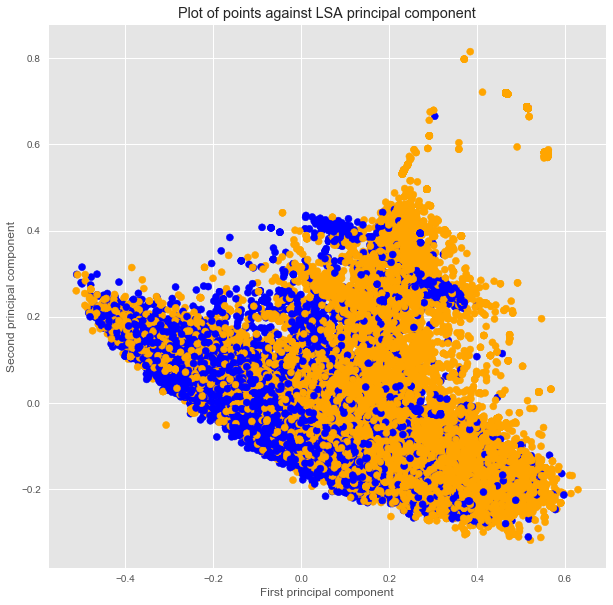

In [58]:

fig = plt.figure(figsize=[10,10])
colors=['blue','orange']
plt.scatter(dtm_lsa[:,1],dtm_lsa[:,2],c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal component for training data')
plt.show()

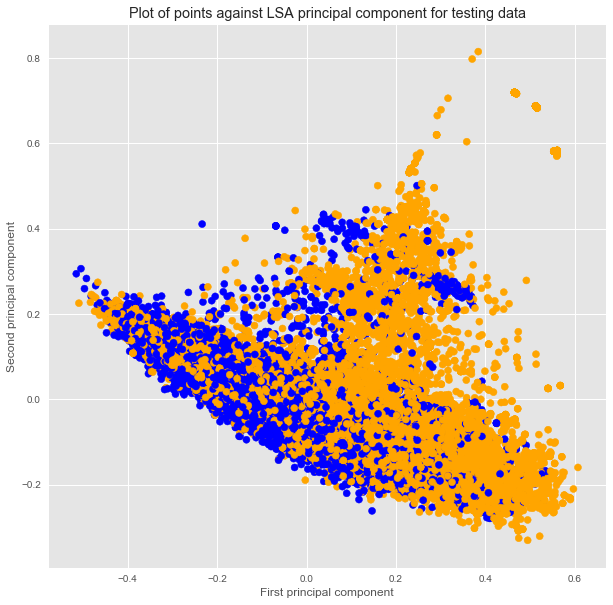

In [60]:
fig = plt.figure(figsize=[10,10])
colors=['blue','orange']
plt.scatter(dtm_lsa_test[:,1],dtm_lsa_test[:,2],c=y_test, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal component for testing data')
plt.show()
plt.show()

### SVMs

In [370]:
#Tune parameters
def tuneparameter(method="linear SVMS"):
    """ 
    Input: dataset, performs croos-validation
    Output: tuning parameters
    """
    C_range = [0.0001,0.001,0.01,0.25,0.5,0.1]
    acc = list()
    for i in C_range:
        if method == "linear SVMS":
            meth = LinearSVC(C=i)
        elif method == "RBF":
            meth = SVC(C=i,kernel="rbf")
        else:
            meth = skl_lm.LogisticRegression(C=i,solver='newton-cg')
        score = meth.fit(X_train_tf,y_train).score(X_test_tf,y_test)
        acc.append(np.mean(score))
        C = C_range[np.argmax(acc)]            
    return C 

In [ ]:
SVM_lin = SVC(C=tuneparameter("linear SVMS"), probability=True,kernel="linear")
SVM_lin.fit(X_train_tf,y_train)
prob_lin = SVM_lin.predict_proba(X_test_tf)
fpr_lin, tpr_lin, threshold_lin = metrics.roc_curve(y_test, pd.DataFrame(prob_lin)[1])
roc_auc_lin = metrics.auc(fpr_lin, tpr_lin)

precision_lin, recall_lin, _ = precision_recall_curve(y_test,pd.DataFrame(prob_lin)[1])
average_precision_lin = average_precision_score(y_test, pd.DataFrame(prob_lin)[1])


In [ ]:
f, axarr = plt.subplots(1,2,figsize=(16,8))
#axarr[0].plot(fpr_log, tpr_log, 'navy', label = 'Logistic AUC = %0.2f' % roc_auc_log)
axarr[0].plot(fpr_lin, tpr_lin, 'orange', label = 'Linear SVM AUC = %0.2f' % roc_auc_lin)
#axarr[0].plot(fpr_svm, tpr_svm, 'g', label = 'RBF SVM AUC = %0.2f' % roc_auc_svm)
axarr[0].plot([0, 1], [0, 1],'r--')
axarr[0].set_xlim([0, 1])
axarr[0].set_ylim([0, 1])
axarr[0].set_ylabel('True Positive Rate')
axarr[0].set_xlabel('False Positive Rate')
axarr[0].legend(loc = 'lower right')
axarr[0].set_title('Receiver Operating Characteristic')


#axarr[1].plot(recall_log, precision_log, color='navy',
#        label='Logistic AUC={0:0.2f}'.format(average_precision_log))
axarr[1].plot(recall_lin, precision_lin, color='orange',
         label='Linear SVM AUC={0:0.2f}'.format(average_precision_lin))
#axarr[1].plot(recall_svm, precision_svm, color='g',
#         label='RBF SVM AUC={0:0.2f}'.format(average_precision_svm))
axarr[1].set_xlabel('Recall')
axarr[1].set_ylabel('Precision')
axarr[1].set_title('Precision-Recall Curve')
axarr[1].legend(loc="lower right")
plt.show()

In [ ]:
pred = lda.fit(X_train_tf, y_train).predict(X_test_tf)
confusion_matrix(y_test, pred).T

### Naive Baysian

In [7]:
#Naive Baysian
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
# get the time to fit and predict the model (for reference speed)
%time nb.fit(X_train_tf, y_train).predict(X_test_tf)

In [ ]:
# get y_predict for X_test_tf
y_predeict = nb.fit(X_train_tf, y_train).predict(X_test_tf)

In [ ]:
# calculate accuracy rate
from sklearn import metrics
metrics.accuracy_score(y_train, y_predict)

In [ ]:
# get the confusion matrix
metrics.confusion_matrix(y_train, y_predict)